In [1]:
# Load libraries# Load libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import pickle
import numpy as np
import os

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import corpus_bleu

# Extract Image Features

In [61]:
model_cnn = VGG16()

model_cnn = Model(inputs = model_cnn.inputs, outputs=model_cnn.layers[-2].output) 
print(model_cnn.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#make a dictionary with the features and the img id as the key 
images_path = 'Flicker8k_Dataset/'
features = {}
count = 0
for img_name in (os.listdir(images_path)):
    img_path = images_path + img_name
    img = load_img(img_path, target_size = (224,224)) #input for vgg is 224,224,3
    img = img_to_array(img)
    
    #reshape data for model
    img = img.reshape((1,img.shape[0], img.shape[1], img.shape[2]))

    img = preprocess_input(img)
    feature = model.predict(img, verbose = 0)
    
    img_id = img_name.split('.')[0]   #name is in the form imgnum.jpg 
    
    #store in the dictionary 
    features[img_id] = feature
    count += 1
    if count % 100 == 1: 
        print (count)

In [103]:
#save the features to a file
pickle.dump(features, open('features.pkl', 'wb'))

In [2]:
#load features from pickle file 
with open('features.pkl', 'rb') as f: 
    features = pickle.load(f)

### Load all the text data

In [4]:
images_path = 'Flicker8k_Dataset/'
captions_path = 'Flickr8k_text/Flickr8k.token.txt'

start_tag = "START"
end_tag = "END"

In [7]:
#get a list of all images in the dataset 
img_list = [os.path.join(file)
        for root, dirs, files in os.walk(images_path)
        for file in files
        if file.endswith('.jpg')]

#remove the .jpg
for i in range (len(img_list)): 
    img_list[i] = img_list[i].split('.')[0]  

## Cleaning the text data

In [8]:
def preprocess_caption(caption):
    #change all to lower case 
    caption = caption.lower()
    
    #remove everything without characters (including digits)
    caption = caption.replace('[^A-Za-z]', '')
    
    #replace multiple spaces with a single space 
    caption = caption.replace('\s+', ' ')
    
    #remove single characters like a, 
    caption = " ".join([word for word in caption.split() if len(word)>1])
    
    #add start and end tags
    caption = start_tag + " " + caption +  " "+ end_tag
    
    
    return caption

In [9]:
#create a mapping from the image name to its caption 
img_to_caption = {}
captions_list = []

#read the captions file
captions = open(captions_path, 'r').read().split("\n") #split bases on each line
for caption in captions: 
    tokens = caption.split("	", 1)
    
    #check for captions that are not valid 
    if len(caption) <= 2: 
        continue 
    
    img_id, caption = tokens[0], tokens[1]
    
    #remove the .jpg 
    img_id = img_id.split('.')[0]    
    
    #process the caption 
    caption = preprocess_caption(caption)
    
    #add captions to a list of available captions
    captions_list.append(caption)
    
    #create an empty list if img id is not there 
    if img_id not in img_to_caption: 
        img_to_caption[img_id] = []
    
    #append caption to the list in the dictionary
    img_to_caption[img_id].append(caption)

In [10]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)

#get the number of unqiue words in all the captions
vocab_size = len(tokenizer.word_index) + 1 
vocab_size

8483

In [11]:
#get the longest caption length for padding the sequence 
max_length = max(len(caption.split()) for caption in captions_list)
max_length

34

## Split into Train and Test

In [12]:
#split the images into training and validation sets
train_ids, valid_ids = train_test_split(img_list, test_size = 0.2)

In [135]:
#Explanation of input and output sequences going into the model
#'START girl going into wooden building END'
#     X                          y 
# START                         girl 
# START girl                    going 
# START gorl going              into 
# START girl going into         wooden 
#....
# stop when y = END

# Model Creation

In [30]:
#for image feature input 
inputs1 = Input(shape = (4096, )) #4096 is the number of features from vgg16 
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

#Text input 
inputs2 = Input(shape = (max_length, ))  #padded each input to max length
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model 
decoder1 = add([fe2, se3]) #concatante the features 
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 256)      2171648     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_3[0][0]']                
                                                                                            

In [13]:
#use a generator to generate data in batches instead of all at once to save space in memory
def data_generator (img_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size): 
    X1, X2, y  = list(), list(), list()
    count = 0
    while 1: 
        for img_id in img_ids: 
            count += 1
            captions = mapping[img_id]
            #process each caption 
            for caption in captions:

                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]   #for each word assign the index
                #split the sequence into X, y pairs
                for i in range (1, len(seq)): 
                    #split into input and output pairs 
                    in_seq, out_seq = seq[:i], seq[i]
                
                    #pad the input sequene to get a common length 
                    in_seq = pad_sequences ([in_seq], maxlen = max_length)[0]
                    
                    #encode out_sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    #store seqs
                    X1.append(features[img_id][0])  #features of the image
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if count == batch_size: 
                X1 = np.array(X1)
                X2 = np.array(X2)
                y = np.array(y)
                
                #send this batch to the model 
                yield [X1, X2], y  
                
                #reset the variables for the next batch        
                count = 0
                X1, X2, y  = list(), list(), list()

## train data 

In [ ]:
epochs = 15 
batch_size = 30 
steps = len(train_ids) // batch_size 
val_results = []
print(steps)
for i in range (epochs):
    print(i)
    generator = data_generator(train_ids, img_to_caption, features, tokenizer, max_length, vocab_size, batch_size)
    #fit for 1 epoch 
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 3)
    
    #get validation score for epochs 2, 5, 10 and 15
    if i in [1,4,9,14]:  
        #Save in between model weights for comparison later
        model.save('model_' + str(i) + '.h5')
        val_results.append(validation_score())

In [45]:
#valid with validation data
def validation_score ():
    actual, predicted = list(), list() 
    for img_id in valid_ids[:100]:
        captions = img_to_caption[img_id]
        #predict the caption
        y_pred = predict_caption(model, features[img_id], tokenizer, max_length)
        #print(y_pred)
        y_pred = y_pred.split()
        #print(captions)
        actl_captions = [caption.split() for caption in captions]
        #print(actl_captions)
        actual.append(actl_captions)
        predicted.append(y_pred)    
    
    BLEU_1 = corpus_bleu(actual, predicted, (1,0,0,0))
    BLEU_2 = corpus_bleu(actual, predicted, (0.5,0.5,0,0))
    BLEU_4 = corpus_bleu(actual, predicted, (0.25,0.25,0.25,0.25))

    return [BLEU_1, BLEU_2, BLEU_4]

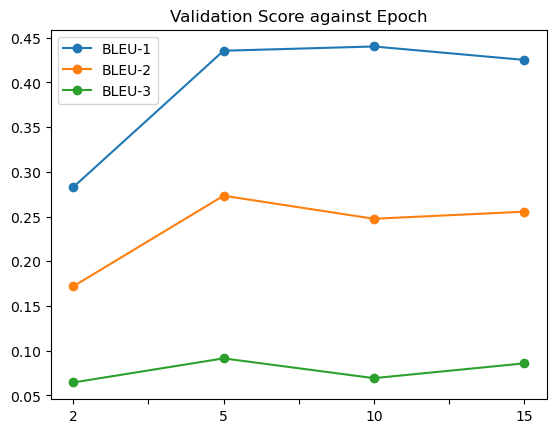

In [40]:
val_results_df = pd.DataFrame(val_results, columns = ['BLEU-1', 'BLEU-2', 'BLEU-3'], index = ['2', '5', '10', '15'])
val_results_df.plot(marker = 'o')
plt.title("Validation Score against Epoch")
plt.show()

In [41]:
val_results_df

,BLEU-1,BLEU-2,BLEU-3
2,0.282852,0.171983,0.064451
5,0.435418,0.273289,0.091402
10,0.440187,0.247514,0.069286
15,0.425176,0.255448,0.085804


# Predicting

In [42]:
def idx_to_word (integer, tokenizer): 
    for word, index in tokenizer.word_index.items(): 
        if index == integer:
            return word
    return None

In [43]:
#generate caption for image 
def predict_caption(model, features, tokenizer, max_length): 
    #add start tag for generation process
    in_text = start_tag
    
    #iterate over the max_length
    for i in range(max_length): 
        #encode input seq 
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #pad sequence
        sequence = pad_sequences([sequence], max_length)
        #predict next word
        yhat = model.predict([features, sequence], verbose = 0)
        #get index with high probability
        yhat = np.argmax(yhat)
        #get word 
        word = idx_to_word(yhat, tokenizer)
        #stop if word is not found or ==END
        if word is None: 
            break

        #append word as input 
        in_text += " " + word
        if word == end_tag or word == 'end': 
            break
    
    return in_text

In [57]:
#Get features for a particular image with img id without the .jpg
def get_features (img_id): 
    img_path = images_path + img_id + ".jpg"
    img = load_img(img_path, target_size = (224,224)) #input for vgg is 224,224,3
    plt.imshow(img)
    img = img_to_array(img)
    
    #reshape data for model
    img = img.reshape((1,img.shape[0], img.shape[1], img.shape[2]))

    img = preprocess_input(img)
    features = model_cnn.predict(img, verbose = 0)
        
    return features

In [63]:
# Generate caption for random image: 
def generate_caption (model, img_id):  
    #get actual caption
    print(img_id)
    
    has_captions = False
    #check if the image has preloaded captions to compare with 
    if img_id in img_to_caption: 
        has_captions = True
        actl_captions = img_to_caption[img_id]
        
    #print image
    img_path = images_path + img_id + ".jpg"
    img = load_img(img_path, target_size = (224,224)) #input for vgg is 224,224,3
    img = img_to_array(img)
    plt.imshow(img)
    
    #get image features
    features = get_features(img_id)
    #predict the caption
    caption = predict_caption(model, features, tokenizer, max_length)
    print("Caption generated: ", caption)
    
    if has_captions: 
        print(actl_captions)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3716272233_7845ec5b3e
Caption generated:  START yellow bird is flying through the air end
['START large white bird goes across the water END', 'START white bird is flying off the water surface END', 'START white bird preparing to catch something in the water END', "START the large white bird 's reflection shows in the water END", 'START white bird walking across wet sand END']


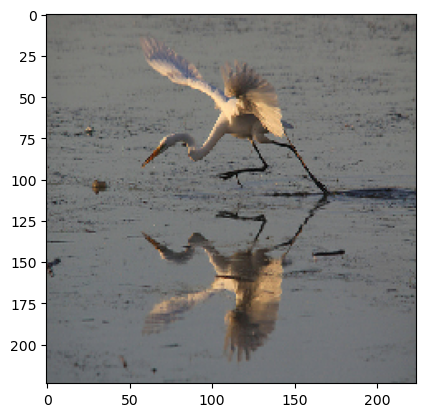

In [67]:
generate_caption(model, '3716272233_7845ec5b3e')